In [115]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [116]:
from src.face import FaceDetector
from src.mask import MaskHandler
from src.utils.project_utils import Utils
from src.region import Region
from src.superpixels import SuperpixelExtractor
from src.feature import FeatureExtractor, EFeature

In [117]:
face_detector = FaceDetector('../assets/lbfmodel.yaml')
IMAGE_PATH = Path('test_images/face.jpg')

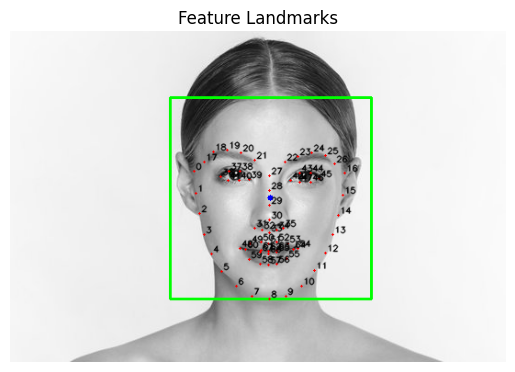

In [118]:
img_rgb, _, _, landmarks_all_faces = face_detector.detect(
    IMAGE_PATH,
    display_indices=True
)

Utils.display(img_rgb, title="Feature Landmarks")

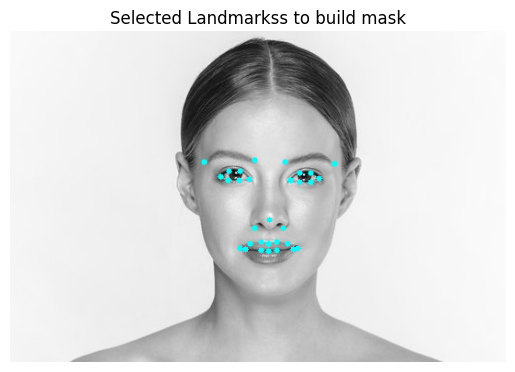

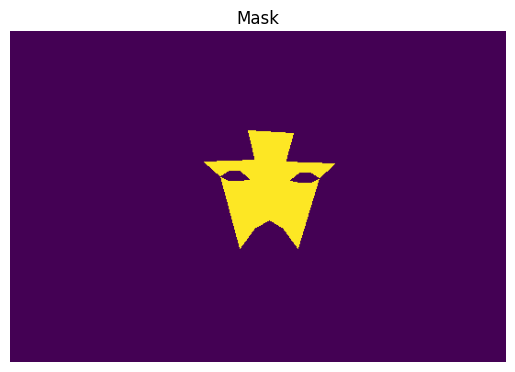

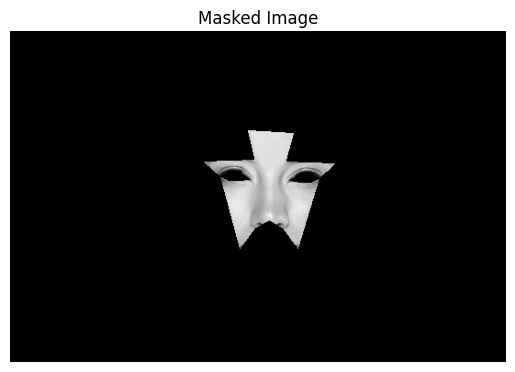

In [119]:
mask_handler = MaskHandler()

masked_img, selected_pts = mask_handler.get_mask_points(
    IMAGE_PATH,
    landmarks_all_faces
)
Utils.display(masked_img, "Selected Landmarkss to build mask")

masks, masked_imgs = mask_handler.build_masks(
    IMAGE_PATH,
    selected_pts,
    landmarks_all_faces
)
Utils.display(masks[0], "Mask")
Utils.display(masked_imgs[0], "Masked Image")

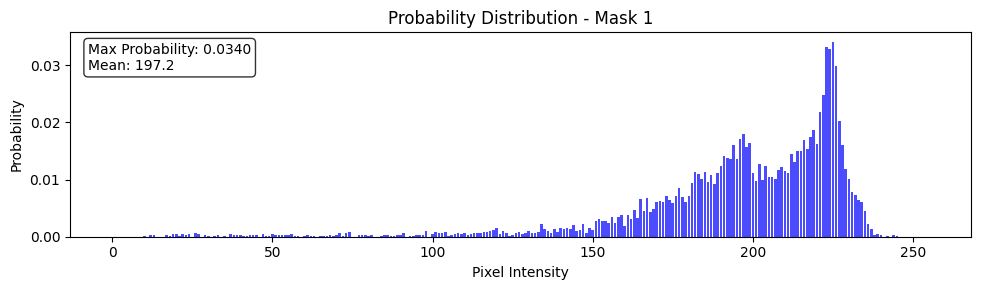

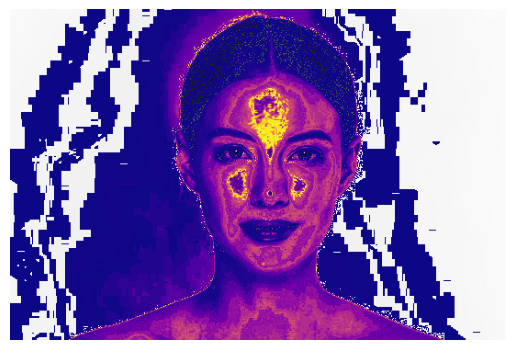

In [120]:
intensity_histograms = mask_handler.get_intensity_histograms(
    IMAGE_PATH,
    masks
)

Utils.visualize_histograms(intensity_histograms)
Utils.apply_intensity_probability_map(IMAGE_PATH, intensity_histograms[0])

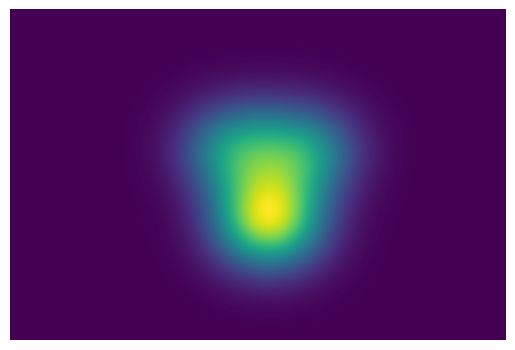

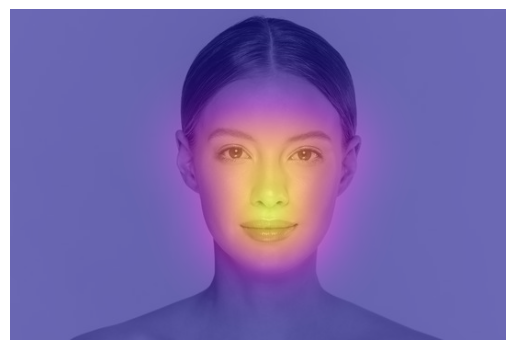

In [121]:
prior_face_masks, heatmaps, heatmaps_blended = mask_handler.get_prior_face_masks(
    IMAGE_PATH, selected_pts
)

idx = 0
Utils.display(prior_face_masks[idx])
Utils.display(heatmaps_blended[idx])

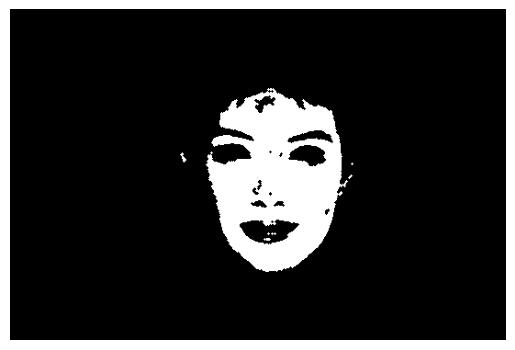

In [122]:
alpha = 0.9
lambda_ = 0.003

skin_pixel_maps = mask_handler.get_skin_pixel_maps(
    IMAGE_PATH,
    intensity_histograms,
    prior_face_masks,
    alpha,
    lambda_,
    selected_pts,
    force_reject=True
)

skin_pixel_maps = [Utils.morphological_cleanup(s) for s in skin_pixel_maps]

Utils.display(skin_pixel_maps[0], cmap="gray")

In [123]:
superpixel_extractor = SuperpixelExtractor()
slic_superpixels, contoured_img, slic_labels, num_superpixels = superpixel_extractor.get_slic_superpixels(IMAGE_PATH)

print(num_superpixels)

1944


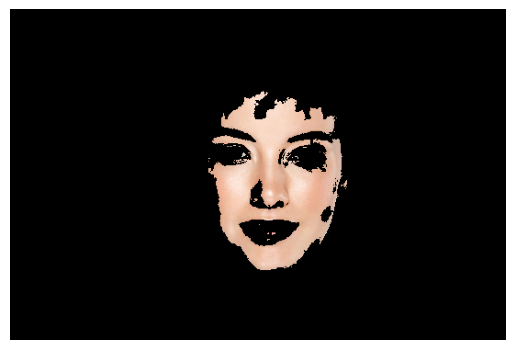

In [124]:
idx = 0
mask_superpixel_labels = superpixel_extractor.get_mask_labels(slic_superpixels, skin_pixel_maps[idx], 0.9)
Utils.display_selected_superpixels(IMAGE_PATH, slic_labels, mask_superpixel_labels)

In [125]:
feature_extractor = FeatureExtractor()
all_feature_vectors = feature_extractor.extract_all_features_superpixels(
    IMAGE_PATH,
    slic_superpixels
)

print(len(all_feature_vectors))

1944


In [126]:
mask_fv, non_mask_fv = FeatureExtractor.separate_feature_vectors(
    all_feature_vectors,
    mask_superpixel_labels
)

print(f"num_mask = {len(mask_fv)} | num_non_mask = {len(non_mask_fv)} | total = {len(mask_fv) + len(non_mask_fv)}")

num_mask = 142 | num_non_mask = 1802 | total = 1944


In [127]:
FEATURE_SELECTION = [
    EFeature.MEAN_INTENSITY,
    EFeature.STD_INTENSITY,
    EFeature.ENTROPY,
    EFeature.LACUNARITY_VECTOR
]

In [128]:
most_favorable_divergence = [
    nfv.get_most_favorable_divergence(mask_fv, FEATURE_SELECTION)
    for nfv in non_mask_fv
    
]

[510, 512, 564, 626, 1702, 1753, 1755, 1758, 1759, 1760, 1800, 1808, 1809, 1814, 1816, 1856, 1871, 1913, 1914]


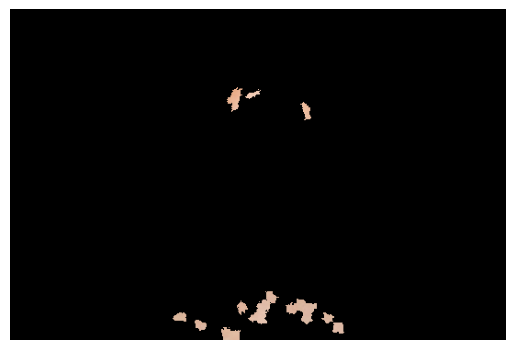

In [129]:
region = Region()

seed_superpixel_labels = region.select_seed_superpixels(
    most_favorable_divergence,
    FEATURE_SELECTION,
    0.99
)

print(seed_superpixel_labels)
Utils.display_selected_superpixels(IMAGE_PATH, slic_labels, seed_superpixel_labels)

Starting Iterations of Region Growing Algorithm
----- Iteration 1/3 -----
Added 143 superpixels: [514, 515, 516, 517, 1539, 1540, 1541, 1048, 1062, 563, 567, 568, 571, 572, 573, 1102, 617, 621, 1647, 1649, 628, 670, 1698, 1700, 1701, 1703, 1704, 1705, 1706, 1210, 1222, 1752, 1754, 1756, 1757, 1761, 1762, 1799, 1801, 779, 1803, 1806, 1807, 1810, 1812, 1813, 1815, 1817, 1853, 1854, 1855, 1857, 1859, 1860, 1861, 1862, 1863, 1867, 1868, 1869, 1870, 1872, 1909, 1910, 1912, 1915, 1925, 1926, 1429, 1436, 939, 458, 459, 460, 1489, 509, 511]
Rejected 197 superpixels: [896, 897, 901, 1161, 1162, 1163, 781, 782, 893, 1169, 786, 787, 789, 791, 1052, 1437, 1061, 1318, 1321, 1322, 1323, 1324, 1326, 944, 1330, 1331, 950, 951, 952, 954, 831, 832, 833, 834, 835, 888, 1223, 1224, 839, 841, 843, 844, 457, 846, 1106, 1746, 725, 726, 727, 1115, 1116, 734, 735, 736, 1374, 1377, 1378, 1383, 616, 1384, 887, 1264, 1008, 1267, 1268, 629, 1269, 1270, 1272, 1273, 886, 1271, 885, 1277, 894, 895]


----- Iteration 

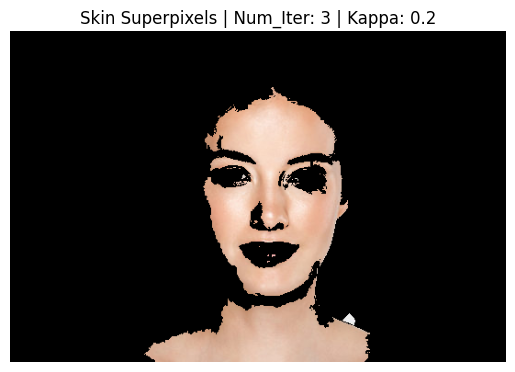

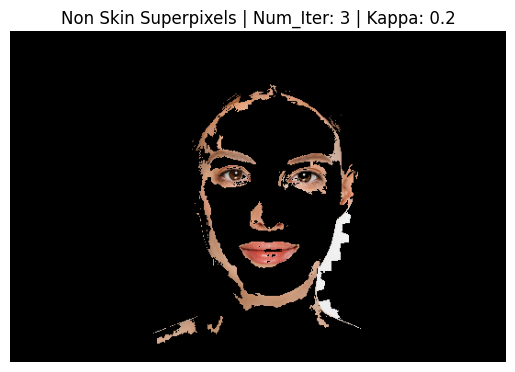

In [130]:
num_iterations = 3
kappa = 0.2

skin_superpixel_labels, non_skin_superpixel_labels = region.grow(
    slic_superpixels,
    seed_superpixel_labels,
    all_feature_vectors,
    most_favorable_divergence,
    mask_superpixel_labels,
    FEATURE_SELECTION,
    num_iterations,
    kappa,
)

Utils.display_selected_superpixels(
    IMAGE_PATH,
    slic_labels,
    skin_superpixel_labels,
    title=f"Skin Superpixels | Num_Iter: {num_iterations} | Kappa: {kappa}"
)

Utils.display_selected_superpixels(
    IMAGE_PATH,
    slic_labels,
    non_skin_superpixel_labels,
    title=f"Non Skin Superpixels | Num_Iter: {num_iterations} | Kappa: {kappa}"
)